### We are going to use Partial Least Squares to find the most important peaks.

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Remove the noise from the spectra using Savitzky–Golay-filtering

In [3]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 3

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = savgol_filter(df['Absorbance'], window_size, poly_order)

Then carry out baseline correction using Asymmetric Least Squares Smoothing to remove the background fluorescence from the spectra.

In [4]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

lam = 10**3  # Adjust the regularisation parameter
p = 0.01    # Adjust the asymmetry parameter
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: baseline_als(x, lam=lam, p=p))

#### One Sample Example

In [5]:
sample = df[df['SpecID'] == "210526-3-04"]

Find the peaks of each the differently smoothed spectra

In [6]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'], distance=152, prominence=42, width=6)
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'], distance=152, prominence=42, width=6)

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

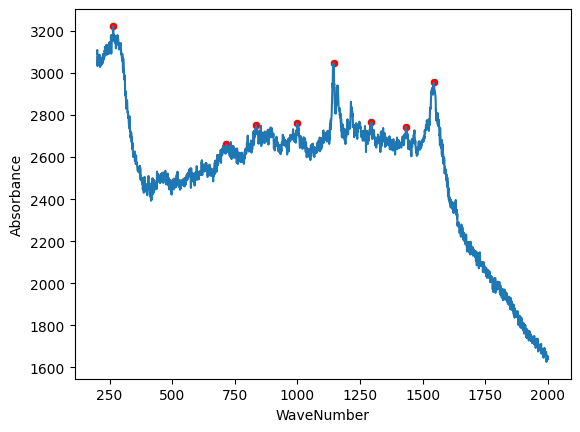

In [7]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

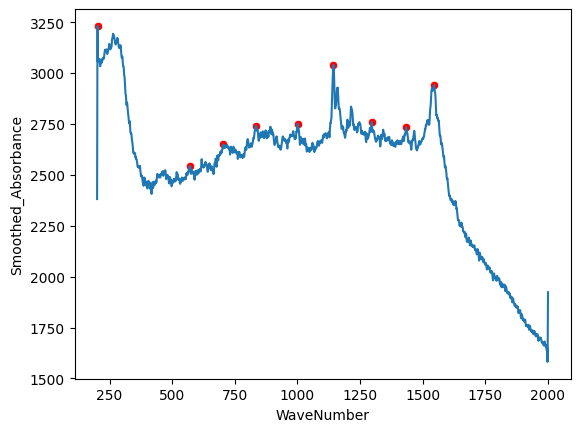

In [8]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

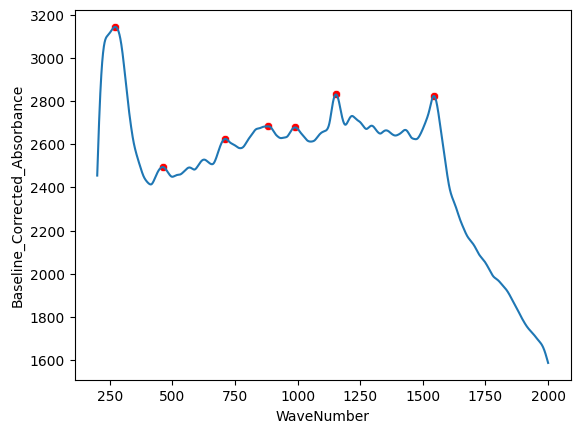

In [9]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

### Peak Selection Using Partial Least Squares

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import LabelEncoder

Pivot the dataframe making each wavenumber a column

In [11]:
wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values='Baseline_Corrected_Absorbance').reset_index()
wavelength_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()
wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')
wavelength_df = wavelength_df.set_index('SpecID')

In [12]:
wavelength_df

,200.0,200.68336,201.36674,202.05011,202.73349,203.41685,204.10023,204.7836,205.46696,206.15034,...,1994.5331,1995.2164,1995.8998,1996.5831,1997.2665,1997.9498,1998.6333,1999.3167,2000.0,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,2662.195411,2658.591717,2654.988533,2651.386748,2647.787558,2644.192427,2640.603063,2637.021401,2633.449504,2629.889528,...,975.859560,970.523128,965.154664,959.768949,954.382045,949.011353,943.675614,938.361243,933.055504,Normal
201210-1-01,2350.414705,2369.329173,2388.172119,2406.875449,2425.377419,2443.623498,2461.564379,2479.155732,2496.357994,2513.136164,...,1128.694612,1122.680933,1116.630130,1110.560200,1104.490642,1098.442586,1092.438915,1086.462261,1080.496481,Normal
201210-1-02,2850.586190,2871.007370,2891.344186,2911.516633,2931.452741,2951.089661,2970.371068,2989.246839,3007.672541,3025.609098,...,1681.630379,1669.383797,1657.038364,1644.640298,1632.239794,1619.891238,1607.653395,1595.483280,1583.340547,Normal
201210-1-03,6334.629518,6441.456451,6547.862439,6653.436199,6757.786469,6860.545967,6961.366582,7059.919981,7155.898006,7249.013229,...,1612.070046,1606.697701,1601.298085,1595.884207,1590.470158,1585.071212,1579.703953,1574.356075,1569.016031,Normal
201210-1-04,2880.837512,2898.634782,2916.360993,2933.948333,2951.335020,2968.466159,2985.291881,3001.767118,3017.851381,3033.508605,...,1613.569744,1607.505034,1601.407883,1595.294492,1589.182395,1583.090606,1577.039701,1571.013735,1564.997817,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1652.247338,1663.990812,1675.696620,1687.329001,1698.855648,1710.248118,1721.480686,1732.530113,1743.375405,1753.997651,...,884.631238,881.069736,877.489999,873.899903,870.308040,866.723750,863.157169,859.601400,856.050003,Hyperglycemia
210526-3-46,1582.332413,1594.739702,1607.108094,1619.400479,1631.583154,1643.626337,1655.503085,1667.189227,1678.663217,1689.906030,...,867.435584,864.327491,861.203651,858.071419,854.938842,851.814713,848.708606,845.613482,842.522780,Hyperglycemia
210526-3-47,1564.099213,1575.524813,1586.914098,1598.232496,1609.448697,1620.535117,1631.466779,1642.221221,1652.778386,1663.120464,...,849.061610,846.297683,843.520346,840.736323,837.952886,835.177916,832.419941,829.672337,826.928913,Hyperglycemia


In [22]:
X = wavelength_df.drop('Status', axis=1)  # Features
y_str = wavelength_df['Status']  # Target variable as strings

# Convert string labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [23]:
n_features_to_select = 7  # Adjust as needed
pls = PLSRegression(n_components=n_features_to_select)
pls.fit(X_train, y_train)

# Extract selected features
X_train_pls = pls.transform(X_train)
X_test_pls = pls.transform(X_test)

In [30]:
from sklearn.metrics import r2_score

# R2 coefficient of determination
r2_train = r2_score(y_train, pls.predict(X_train))
r2_test = r2_score(y_test, pls.predict(X_test))

print(f"R2 (Train): {r2_train}")
print(f"R2 (Test): {r2_test}")

R2 (Train): 0.10222791998268688
R2 (Test): 0.07489076058692723


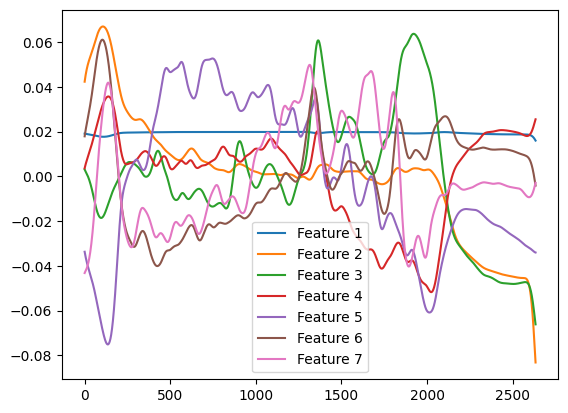

In [29]:
import matplotlib.pyplot as plt

load_curves = pls.x_loadings_
for i in range(n_features_to_select):
    plt.plot(load_curves[:, i], label=f'Feature {i+1}')

plt.legend()
plt.show()